Convert between two angles and a displacement $(\alpha, \beta, Z)$ and the linear displacements of each actuator $(A, B, C)$

\begin{equation}
    (\alpha, \beta, Z) \longleftrightarrow (A, B, C)
\end{equation}


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.dpi' : 100,
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest'
})

import numpy as np
from itertools import product

In [12]:
# (A, B, C) ---> (alpha, beta, Z)

def get_alpha(A,B,C,a):
    return 1./a * (A - 0.5 * (B + C))

def get_beta(B,C,b):
    return 1./b * (B - C)

def get_Z(A,B,C):
    return 1./3. * (A + B + C)


# (alpha, beta, Z) ---> (A, B, C)

def get_A(alpha, Z, a):
    return Z + 2./3. * a * alpha

def get_B(alpha, beta, Z, a, b):
    return 0.5 * b * beta + Z - 1./3. * a * alpha

def get_C(alpha, beta, Z, a, b):
    return Z - 1./3. * a * alpha - 1./2. * b * beta

# vectors

def ABC_to_alphabetaZ(A,B,C,a,b):
    return get_alpha(A,B,C,a), get_beta(B,C,b), get_Z(A,B,C)

def alphabetaZ_to_ABC(alpha,beta,Z,a,b):
    return get_A(alpha,Z,a), get_B(alpha,beta,Z,a,b), get_C(alpha,beta,Z,a,b)

# constraints

def get_alphamin(Amin, Bmax, Cmax, a):
    return 1./a * (Amin - 0.5*(Bmax + Cmax))
    
def get_alphamax(Amax, Bmin, Cmin, a):
    return 1./a * (Amax - 0.5*(Bmin + Cmin))

def get_betamin(Bmin, Cmax, b):
    return 1./b * (Bmin - Cmax)

def get_betamax(Bmax, Cmin, b):
    return 1./b * (Bmax - Cmin)

# command to voltages (DAC?)

def command_to_DAC(alpha, beta, Z, fsmprops):
    '''
    Given two angles and a mean dispacement, convert to DAC values
    '''
    
    # first, check that requested values are valid
    # (should this happen here? or allow invalid values to pass and clip the DAC values?)
    alpha_cl = np.clip(alpha, fsmprops['alphamin'], fsmprops['alphamax'])
    beta_cl = np.clip(beta, fsmprops['betamin'], fsmprops['betamax'])
    Z_cl = np.clip(Z, fsmprops['Zmin'], fsmprops['Zmax'])
    #print(alpha_cl, beta_cl, Z_cl)
    
    # get linear actuator displacement (A,B,C)
    A = get_A(alpha_cl, Z_cl, fsmprops['a'])
    B = get_B(alpha_cl, beta_cl, Z_cl, fsmprops['a'], fsmprops['b'])
    C = get_C(alpha_cl, beta_cl, Z_cl, fsmprops['a'], fsmprops['b'])
    
    return A, B, C
    
    # convert (A,B,C) to DAC values ?
    #Adac, Bdac, Cdac = ABC_to_ABCdac(A,B,C,fsmprops['disp2dac'])
    
def ABC_to_ABCdac(A,B,C, disp2dac):
    pass

In [19]:
fsmprops['alphamin'], fsmprops['alphamax'], fsmprops['betamin'], fsmprops['betamax']

(-0.001153846153846154, 0.001153846153846154, -0.001, 0.001)

In [20]:
# example properties
a = 10.4e-3 #mm
b = 12.0e-3 #mm

Amin = Bmin = Cmin = 0e-6 #um
Amax = Bmax = Cmax = 12e-6 #um
Zmin = 0e-6 #um
Zmax = 12e-6 #um

fsmprops = {
    'a' : a,
    'b' : b,
    'Amin' : Amin,
    'Bmin' : Bmin,
    'Cmin' : Cmin,
    'Amax' : Amax,
    'Bmax' : Bmax,
    'Cmax' : Cmax,
    'disp2dac' : 1.0,
}

fsmprops.update({
    'alphamin' : get_alphamin(fsmprops['Amin'], fsmprops['Bmax'], fsmprops['Cmax'], fsmprops['a']),
    'betamin'  : get_betamin(fsmprops['Bmin'], fsmprops['Cmax'], fsmprops['b']),
    'Zmin'     : Zmin,
    'alphamax' : get_alphamax(fsmprops['Amax'], fsmprops['Bmin'], fsmprops['Cmin'], fsmprops['a']),
    'betamax'  : get_betamax(fsmprops['Bmax'], fsmprops['Cmin'], fsmprops['b']),
    'Zmax'     : Zmax
})

print(fsmprops['alphamin'], fsmprops['alphamax'], fsmprops['betamin'], fsmprops['betamax'])

-0.001153846153846154 0.001153846153846154 -0.001 0.001


In [5]:
Zvals = np.linspace(0, 12, num=101) * 1e-6

allmask = []
for Z in Zvals:

    alphavals = np.linspace(fsmprops['alphamin'], fsmprops['alphamax'], num=100)
    betavals = np.linspace(fsmprops['betamin'], fsmprops['betamax'], num=100)
    #Z = 6e-6 #optimal?

    #alphavals = betavals = np.linspace(-2e-3, 2e-3, num=100)

    alphabeta = product(alphavals, betavals)

    allABC = []
    for (alpha, beta) in alphabeta:
        ABC = command_to_DAC(alpha, beta, Z, fsmprops)
        allABC.append(ABC)

    allABC = np.asarray(allABC).reshape((100,100,3)).swapaxes(0,-1)

    Amask =  (allABC[0] >= fsmprops['Amin']) & (allABC[0] <= fsmprops['Amax'])
    Bmask =  (allABC[1] >= fsmprops['Bmin']) & (allABC[1] <= fsmprops['Bmax'])
    Cmask =  (allABC[2] >= fsmprops['Cmin']) & (allABC[2] <= fsmprops['Cmax'])
    mask = Amask & Bmask & Cmask
    
    allmask.append(mask)

In [6]:
allmask = np.asarray(allmask)

(1.4e-05, 8.000000000000001e-06, -4e-06)


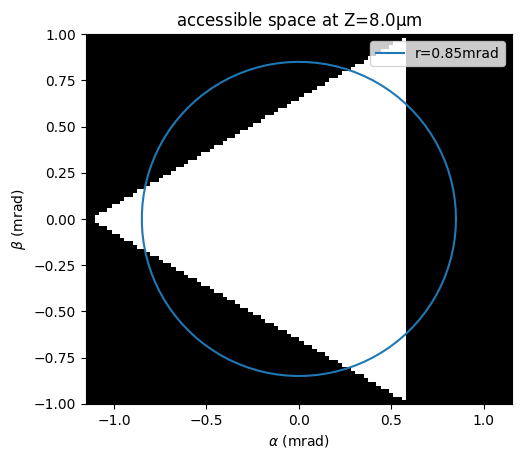

In [8]:
import labellines as ll

idx = 67#33#50
Z = Zvals[idx] # 6um
mask = allmask[idx]

# need to double check all this
extent=np.asarray([fsmprops['alphamin'], fsmprops['alphamax'], fsmprops['betamin'], fsmprops['betamax']]) * 1e3
#extent = np.asarray([alphavals.min(), alphavals.max(), alphavals.min(), alphavals.max()]) * 1e3

plt.imshow(mask, extent=extent, cmap='Greys_r')
#plt.colorbar()
plt.ylabel('$\\beta\ (\mathrm{mrad})$')
plt.xlabel('$\\alpha\ (\mathrm{mrad})$')
plt.title(f'accessible space at Z={Z*1e6:.1f}' + '$\mathrm{\mu m}$')


r = 0.85 # mrad
theta = np.linspace(0, 2*np.pi, num=100)
x = r * np.cos(theta)
y = r * np.sin(theta)
plt.plot(x, y, label=f'r={r}mrad')
plt.legend()
#ll.labelLines()

print(alphabetaZ_to_ABC(alpha,beta,6e-6,a,b))

In [9]:
masksum = np.sum(allmask.astype(float), axis=0)

(1.4e-05, 8.000000000000001e-06, -4e-06)


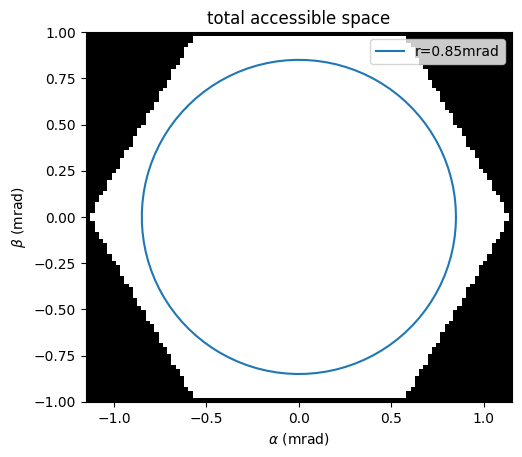

In [10]:
# need to double check all this
extent=np.asarray([fsmprops['alphamin'], fsmprops['alphamax'], fsmprops['betamin'], fsmprops['betamax']]) * 1e3
#extent = np.asarray([alphavals.min(), alphavals.max(), alphavals.min(), alphavals.max()]) * 1e3

plt.imshow(masksum > 1e-16, extent=extent, cmap='Greys_r')
#plt.colorbar()
plt.ylabel('$\\beta\ (\mathrm{mrad})$')
plt.xlabel('$\\alpha\ (\mathrm{mrad})$')
plt.title(f'total accessible space')


r = 0.85 # mrad
theta = np.linspace(0, 2*np.pi, num=100)
x = r * np.cos(theta)
y = r * np.sin(theta)
plt.plot(x, y, label=f'r={r}mrad')
plt.legend()
#ll.labelLines()

print(alphabetaZ_to_ABC(alpha,beta,6e-6,a,b))